Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


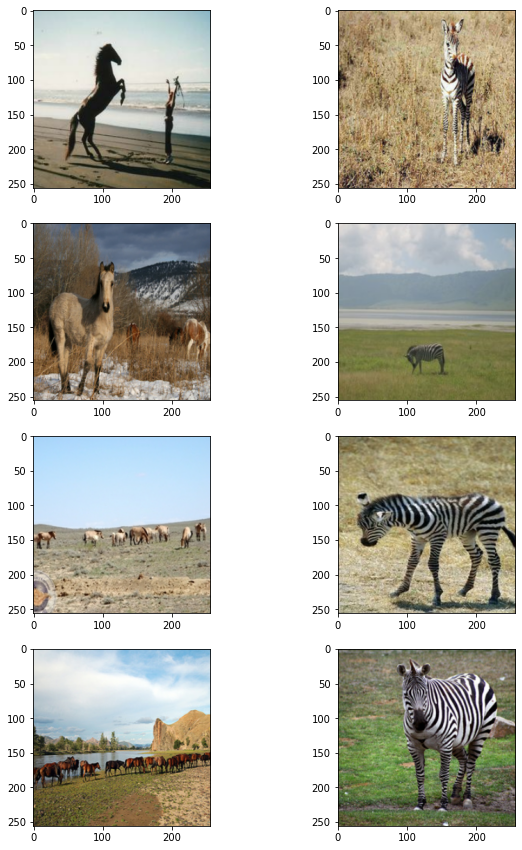

In [4]:
import os
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import sklearn

#import tensorflow_addons as tfa
import tensorflow_datasets as tfds


# 데이터 적재, 전처리, 배치 하는 과정을 TF가 알아서 수행하도록
autotune = tf.data.AUTOTUNE

dataset, _ = tfds.load("cycle_gan/horse2zebra", with_info = True, as_supervised=True)
train_horses, train_zebras = dataset["trainA"], dataset["trainB"]
test_horses, test_zebras = dataset["testA"], dataset["testB"]

# 평균 이미지 크기
orig_img_size = (286, 286)
# input image size, 만약 이미지 사이즈가 다 다르다면 맞춰줄 필요가 있음, 그리고 RGB이기 때문에 3임
input_img_size = (256, 256, 3)

 # 각 레이어별 layer의 weight 초기화 --> 1. 초기화 방법에 따른 결과를 비교해보자.
kernel_init = keras.initializers.RandomNormal(stddev=0.02)
gamma_init = keras.initializers.RandomNormal(stddev=0.02)

buffer_size = 256
batch_size = 1

def normalize_img(img):
  # img의 데이터 타입을 변환
  img = tf.cast(img, dtype=tf.float32)
  # -1과 1사이의 값으로 변환
  return (img / 127.5 ) - 1.0

#data augementation
def preprocess_train_image(img, label):
  # 이미지 랜덤하게 좌우반전
  img = tf.image.random_flip_left_right(img)
  # 입력 이미지의 크기를 변경
  img = tf.image.resize(img, [*orig_img_size])
  # 이미지를 256x256으로 랜덤하게 잘라냄 이 때 크기는 256 256
  img = tf.image.random_crop(img, size=[*input_img_size])
  # 픽셀의 값들을 -1과 1 사이로 정규화
  img = normalize_img(img)

  return img

# 테스트 이미지는 이미지 크기만 변환
def preprocess_test_image(img, label):
    img = tf.image.resize(img, [input_img_size[0], input_img_size[1]])
    img = normalize_img(img)
    return img

# 학습 데이터 전처리
train_horses = (
    train_horses.map(preprocess_train_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)
train_zebras = (
    train_zebras.map(preprocess_train_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)

# 테스트 데이터 전처리
test_horses = (
    test_horses.map(preprocess_test_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)
test_zebras = (
    test_zebras.map(preprocess_test_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)

# 몇몇 데이터 확인
_, ax = plt.subplots(4, 2, figsize=(10, 15))
for i, samples in enumerate(zip(train_horses.take(4), train_zebras.take(4))):
    horse = (((samples[0][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
    zebra = (((samples[1][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
    ax[i, 0].imshow(horse)
    ax[i, 1].imshow(zebra)
plt.show()




